Python modules used for the hackathon.

In [1]:
# !/usr/bin/python -m pip install --upgrade pip
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install matplotlib
# !pip install scikit-image
# !pip install cv2
# !pip install tabulate
# !pip install -q -U keras-tuner
# !pip uninstall protobuf python3-protobuf
# !pip install --upgrade pip
# !pip install --upgrade protobuf
# !pip install graphviz


In [2]:
import os
import datetime
import re
import glob

import IPython
import IPython.display
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, silhouette_score
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras_tuner as kt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.special import softmax

import warnings
warnings.filterwarnings('ignore')

2021-12-05 06:04:46.696710: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
gdrive = '/home/ai_team26/shell_hack/go/bin/gdrive'
data_path = '/home/ai_team26/shell_hack/load_dir/data_to_nvidia'
training_data_key = 'Data_Train'
testing_data_key = 'Data_Test'

training_path = os.path.join(data_path, training_data_key)
testing_path = os.path.join(data_path, testing_data_key)
resized_imgs_dir = os.path.join(data_path, 'Data_Img')
imgs_ds_path = os.path.join(data_path, 'Data_Img_DS')
img_kind = "Projection"
img_x = img_y = 40
imgs_ds_np_path = '{}/{}x{}_{}.npy'.format(imgs_ds_path, img_x, img_y, img_kind)

training_csv_path = os.path.join(training_path, 'weather_data.csv')
testing_csv_path = os.path.join(testing_path, 'weather_data.csv')
test_csv_file_template = os.path.join(testing_path, '{}/weather_data.csv')
pred_default_location = os.path.join(data_path,'submissions/predictions.csv')
public_leader_location = os.path.join(data_path,'Public_LeaderBoard.csv')
drive_pred_id = '1UEoshMeBb5lCll29clUYqyVN-i3_HFjd'
drive_public_leader_board_id = '1k79ujc-fbPhlPjg2ROJkIYOsLUdX-Uvm'

target_col = 'Global CMP22 (vent/cor) [W/m^2]'
date_col = 'DATE (YYYY/MM/DD)_MST'
scenario_set_col = 'scenario_set'
img_path_col = 'img_path'
img_index_col = 'img_index'
imgs_ds_np_path = '{}/{}x{}_{}.npy'.format(imgs_ds_path, img_x, img_y, img_kind)
img_unavailable = -100

img_time_sine_col = 'Img Day sin'
img_time_cos_col = 'Img Day cos'
year_sine_col = 'Year sin'
year_cos_col = 'Year cos'
day_sine_col = 'Day sin'
day_cos_col = 'Day cos'
target_day_sine_col = 'Target Day sin'
target_day_cos_col = 'Target Day cos'
is_train_col = 'is_train'

target_date_cols = [target_day_sine_col, target_day_cos_col]
INPUT_STEPS = 12
SAMPLING_RATE = 10

OUTPUT_STEPS = 12

IMG_DELAY_TOLERANCE = 3

cloud_coverage_col = 'Total Cloud Cover [%]'
precipitation_col = 'Precipitation (Accumulated) [mm]'
moisture_col = 'Moisture'

feature_cols_for_outliers = [target_col, 'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', cloud_coverage_col,
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', precipitation_col,
       'Snow Depth [cm]', moisture_col, 'Albedo (CMP11)']

non_neg_feature_cols = [target_col, 'Direct sNIP [W/m^2]', cloud_coverage_col ]

time_series_cols = [target_col, 'Direct sNIP [W/m^2]', 'Tower Dry Bulb Temp [deg C]',
       'Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]',
       'Tower RH [%]', cloud_coverage_col, 'Station Pressure [mBar]',
        'Snow Depth [cm]', 'Albedo (CMP11)', precipitation_col,
        'Wind x','Wind y', 'Azimuth sin', moisture_col,
        'Azimuth cos', day_sine_col, day_cos_col, year_sine_col, year_cos_col]


img_cols = [img_index_col, img_time_sine_col, img_time_cos_col]

feature_cols_for_prepare = time_series_cols + [img_index_col]
day_start_idx_col = 'day_start_idx'
feature_start_idx_col = 'feature_start_idx'
feature_steps_col = 'feature_steps'
feature_end_idx_col = 'feature_end_idx'
total_end_idx_col = 'total_end_idx'
cluster_col = 'cluster'
index_col = 'index'

idx_df_cols = [cluster_col, scenario_set_col, index_col, day_start_idx_col, feature_start_idx_col, 
                  feature_end_idx_col, total_end_idx_col, feature_steps_col]

cluster_idx = idx_df_cols.index(cluster_col)
day_start_idx = idx_df_cols.index(day_start_idx_col)
feature_start_idx = idx_df_cols.index(feature_start_idx_col)
feature_end_idx = idx_df_cols.index(feature_end_idx_col)
total_end_idx = idx_df_cols.index(total_end_idx_col)

pred_df_cols = ['{}_min_horizon'.format(p) for p in range(10, 130, 10)]

In [4]:
def convert_time_stamp_to_vector(timestamps, freq='day'):
    if freq == 'day':
        divisor = 24*60*60
    elif freq == 'year':
        divisor = (365.2425)*(24*60*60)
    else: 
        raise Exception('Frequency not supported')
        
    timestamp_s = (timestamps - pd.Timestamp("2010-01-01")).dt.total_seconds()
    sine_series = np.sin(timestamp_s * (2 * np.pi / divisor))
    cos_series = np.cos(timestamp_s * (2 * np.pi / divisor))
    return sine_series, cos_series
    

Prepare images

In [5]:
with open(imgs_ds_np_path, 'rb') as f:
    all_images = np.divide(np.load(f).reshape(-1, img_x, img_y, 3), 255)
    all_image_paths = np.load(f)
all_images_tensor = tf.constant(all_images, dtype=tf.float32)

def prepare_img_df(img_paths_arr):
    img_df = pd.DataFrame()
    img_df[img_path_col] = img_paths_arr
    img_df[img_index_col] = list(range(img_paths_arr.shape[0]))
    img_date_extractor_fn = (lambda img_path: re.search(r"\d+", img_path.split('-')[-1]).group())
    img_src_extractor_fn = (lambda img_path: str(img_path).split('-')[0])
    img_df[date_col] = pd.to_datetime(img_df[img_path_col].apply(img_date_extractor_fn), format="%Y%m%d%H%M%S")
    img_df['src'] = img_df[img_path_col].apply(img_src_extractor_fn)
    img_df = img_df[~img_df[date_col].duplicated(keep='first')]
    img_df[img_time_sine_col], img_df[img_time_cos_col] = convert_time_stamp_to_vector(img_df[date_col], 
                                                                                       freq='day')
    return img_df

all_image_info_df = prepare_img_df(all_image_paths)
train_image_paths_df = all_image_info_df[all_image_info_df['src'] == training_data_key].reset_index(drop=True)
test_image_paths_df = all_image_info_df[all_image_info_df['src'] == testing_data_key].reset_index(drop=True)
clear_output()

In [6]:
# !{gdrive} upload -r -p "1tb4xPinTSMU7DyLW1K-sdU53qAv7SfX0" {training_path}/20200501

We converted all individual test scenario files into single test file for easy usage. Following script need to be executed only one time.

In [7]:
# test_dfs=[]
# for i in range(1, 301):
#     test_file = test_csv_file_template.format(i)
#     df = pd.read_csv(test_file)
#     test_dfs.append(df)

# for idx, test_df in enumerate(test_dfs):
#   test_df['scenario_set'] = idx+1

# test_df = pd.concat(test_dfs, axis=0).reset_index(drop=True)
# test_df.to_csv(testing_path, index=False)

Read train and test datasets and convert to pandas Dataframes.


In [8]:
train_df = pd.read_csv(training_csv_path, parse_dates=[[0,1]])
test_df = pd.read_csv(testing_csv_path, parse_dates=[[0,1]])
train_df[scenario_set_col] = train_df[date_col].dt.strftime('%Y%m%d').astype(int)
train_df[is_train_col] = True
test_df[is_train_col] = False

Define commonally used variables

In [9]:
# Mutual information scores
# def make_mi_scores(X, y):
#     mi_scores = mutual_info_regression(X, y)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

Calculate z-scores and remove outliers

In [10]:
def fill_outliers(df, features):
    for col in features:
        z_scores = np.abs(zscore(df[col])) > 3
        df.at[z_scores, col] = np.nan
    return df

def fill_na(df, axis=None):
    df = df.fillna(method='ffill', axis=axis)
    df = df.fillna(method='bfill', axis=axis)
    df = df.fillna(0)
    return df
        
def fill_non_neg_feature_cols(df, feature_cols):
    for non_neg_feature_col in feature_cols:
        neg_values =  df[non_neg_feature_col] < 0
        df.at[neg_values, non_neg_feature_col] = np.nan
        df[non_neg_feature_col] = fill_na(df[non_neg_feature_col])
    return df

def resample_groupwise(df, groupby=scenario_set_col, rule='{}T'.format(SAMPLING_RATE), agg='mean'):
    new_dfs = []
    for group_key, sub_df in df.groupby(groupby):
        sub_df = sub_df.set_index(date_col).resample(rule).agg(agg).reset_index()
        sub_df[groupby] = group_key
        new_dfs.append(sub_df)
    return pd.concat(new_dfs, axis=0).reset_index(drop=True)

def perform_cleanup(df):
    valid_indices = df.index[df[target_col] >= 0]
    min_valid = min(valid_indices)
    max_valid = max(valid_indices)  
    df = df.loc[min_valid:max_valid]
    df[feature_cols_for_outliers] = fill_na(df[feature_cols_for_outliers])
    df = fill_non_neg_feature_cols(df, non_neg_feature_cols) 
    return df.reset_index(drop=True)

def fill_na_groupwise(df, groupby=scenario_set_col):
    new_dfs = []
    for group_key, sub_df in df.groupby(groupby):
        sub_df = sub_df.sort_values(date_col).reset_index(drop=True)
        sub_df = perform_cleanup(sub_df)
        sub_df = sub_df.set_index(date_col)
        sub_df_target = sub_df[[target_col]].copy()
        sub_df = sub_df.resample(pd.Timedelta(minutes=SAMPLING_RATE)).mean().reset_index()
        sub_df_target = sub_df_target.resample('{}T'.format(SAMPLING_RATE)).last().reset_index()
        sub_df[target_col] = sub_df_target[[target_col]]
        new_dfs.append(sub_df)
    new_df = pd.concat(new_dfs, axis=0).reset_index(drop=True)
    return new_df


**perform_preprocessing** does the following feature Engineering steps: 
* Converted wind speed into wind velocity vector (velocity along x and y axes)
* Converted Azimuth angle in agree to sin and cos values as they better captures the cyclic nature.
* Used Forward-Fill (ffill method in pandas) to fill the missing values in target column.
* Convert date to cyclic features to capture seasons

In [11]:
def perform_preprocessing(df,img_df, img_delay_tolerance_duration):
    peak_wind_speed_col = 'Peak Wind Speed @ 6ft [m/s]'
    avg_wind_dir_col = 'Avg Wind Direction @ 6ft [deg from N]'
    azimuth_angle_col = 'Azimuth Angle [degrees]'

    wind_speed = pd.Series(df.pop(peak_wind_speed_col))
    bad_wv = wind_speed < 0
    wind_speed[bad_wv] = 0.0
    wind_angle = df.pop(avg_wind_dir_col)*np.pi / 180

    df['Wind x'] = wind_speed*np.cos(wind_angle)
    df['Wind y'] = wind_speed*np.sin(wind_angle)

    azimuth_angle = df.pop(azimuth_angle_col) * np.pi/180
    df['Azimuth sin'] = np.sin(azimuth_angle)
    df['Azimuth cos'] = np.cos(azimuth_angle)

    day = 24*60*60
    year = (365.2425)*day

    df = df.join(img_df.set_index(date_col)[img_cols], how='left', on=date_col)
    df[img_cols] = df[img_cols].fillna(method='ffill', limit=img_delay_tolerance_duration)
    df[img_cols] = df[img_cols].fillna(img_unavailable)
    df[[scenario_set_col, img_index_col]] = df[[scenario_set_col, img_index_col]].astype(np.int32)

    df[day_sine_col], df[day_cos_col] = convert_time_stamp_to_vector(df[date_col], freq='day')
    target_dates = df[date_col] + pd.Timedelta(minutes=INPUT_STEPS*SAMPLING_RATE)
    df[target_day_sine_col], df[target_day_cos_col] = convert_time_stamp_to_vector(target_dates, freq='day')
    df[year_sine_col], df[year_cos_col] = convert_time_stamp_to_vector(df[date_col], freq='year')
    
    df = df.drop(columns=[is_train_col])
    return df


In [12]:
clean_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
clean_df = fill_outliers(clean_df, feature_cols_for_outliers)
train_df_cleaned = clean_df[clean_df[is_train_col]].reset_index(drop=True)
train_df_cleaned = fill_na_groupwise(train_df_cleaned, scenario_set_col)
test_df_cleaned = clean_df[~clean_df[is_train_col]].reset_index(drop=True)
test_df_cleaned = fill_na_groupwise(test_df_cleaned, scenario_set_col)
print("After clearing outliers", train_df.shape, train_df_cleaned.shape, test_df.shape, test_df_cleaned.shape)
del(clean_df)
train_df_cleaned = perform_preprocessing(train_df_cleaned, train_image_paths_df, IMG_DELAY_TOLERANCE*SAMPLING_RATE)
test_df_cleaned = perform_preprocessing(test_df_cleaned, test_image_paths_df, IMG_DELAY_TOLERANCE*SAMPLING_RATE)
print("After perform_preprocessing", train_df_cleaned.shape, test_df_cleaned.shape)

After clearing outliers (527040, 18) (28091, 18) (110000, 18) (11269, 18)
After perform_preprocessing (28091, 27) (11269, 27)


### Clustering

In [13]:
num_clusters=4
cluster_cols = time_series_cols
train_df_agg = train_df_cleaned.groupby(scenario_set_col).mean()
test_df_agg = test_df_cleaned.groupby(scenario_set_col).mean()

def apply_kmeans_clustering():
    cluster_scaler = StandardScaler()
    train_df_agg_scaled = cluster_scaler.fit_transform(train_df_agg[cluster_cols])
    test_df_agg_scaled = cluster_scaler.transform(test_df_agg[cluster_cols])

    kmeans = KMeans(n_clusters=num_clusters)
    train_df_agg[cluster_col] = kmeans.fit_predict(train_df_agg_scaled)
    test_df_agg[cluster_col] = kmeans.predict(test_df_agg_scaled)
    
def apply_date_based_clustering():
    def map_to_cluster(month):
        if month < 4 or month > 9:
            return 0
        else:
            return 1
    train_df_agg[cluster_col] = train_df_agg[date_col].dt.month.apply(map_to_cluster)
    test_df_agg[cluster_col] = test_df_agg[date_col].dt.month.apply(map_to_cluster)

apply_kmeans_clustering()

train_df_agg = train_df_agg.reset_index()
test_df_agg = test_df_agg.reset_index()
train_df_cleaned[cluster_col] = pd.merge(train_df_cleaned[[scenario_set_col]], train_df_agg[[scenario_set_col, cluster_col]], 
                                   how='left', on=scenario_set_col)[cluster_col]
test_df_cleaned[cluster_col] = pd.merge(test_df_cleaned[[scenario_set_col]], test_df_agg[[scenario_set_col, cluster_col]], 
                                   how='left', on=scenario_set_col)[cluster_col]
print("After clustering", train_df_cleaned.shape, test_df_cleaned.shape)
print("Train\n", train_df_cleaned[cluster_col].value_counts(),"\nTest\n", test_df_cleaned[cluster_col].value_counts())

After clustering (28091, 28) (11269, 28)
Train
 3    11395
2     7828
0     5346
1     3522
Name: cluster, dtype: int64 
Test
 2    5549
3    4585
1    1135
Name: cluster, dtype: int64


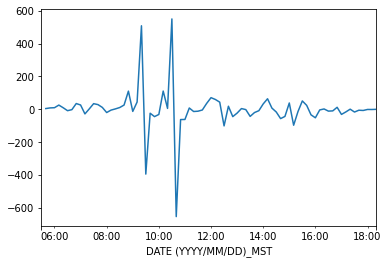

In [14]:
def draw_trend(df, scenario_set):
    df = df.copy().set_index(date_col)
    target = df[df[scenario_set_col]==scenario_set][target_col]
    target_diff = target - target.shift(1)
    target_diff.plot()
draw_trend(train_df_cleaned, 20200910)

<AxesSubplot:xlabel='DATE (YYYY/MM/DD)_MST'>

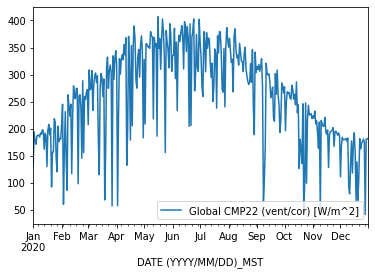

In [15]:
df = train_df_cleaned.copy().set_index(date_col)
df[[target_col]].resample('1D').std().plot()

Relation between features and target

In [16]:
# print("Train df:\n", make_mi_scores(train_df_cleaned.loc[:, feature_cols], train_df_cleaned[target_col]))
# print("Test df:\n", make_mi_scores(test_df_cleaned.loc[:, feature_cols], test_df_cleaned[target_col]))

**prepare_timeseries_records** function takes time series dataset coverts to multi-step regression problem.

Example: This function converts following dataframe

Time | Feature1 | Feature2
-----|----------|--------
T1   | 1.1 | 2.1 
T2   | 1.2 | 2.2
T3   | 1.3 | 2.3 

to

Feature1-1 | Feature2-1 | Feature1-2 | Feature2-2 
-----------|------------|------------|-----------
1.1        | 1.2        | 2.1        | 2.2 
1.2        | 1.3        | 2.2        | 2.3 


**prepare_dfs** groups dataset by date/scenario and creates train and test datasets using above functions.
* We are grouping dataset by date so that data is not combined across different dates as we need to predict using data within a day in the test set. 
* We are also ignoring data with missing values from at start and end of the day. 


In [17]:
def prepare_index_rages(day_index_start, day_index_end, min_feature_steps,
                        max_feature_steps, target_steps):
    total_end_range = np.arange(day_index_start+min_feature_steps+target_steps, day_index_end+1).reshape(-1,1)
    feature_end_range = total_end_range - target_steps
    steps_to_generate = np.arange(min_feature_steps, max_feature_steps+1, 3).reshape(1, -1)
    feature_start_range = np.subtract(feature_end_range, steps_to_generate)
    feature_start_range[feature_start_range<day_index_start]=day_index_start
    feature_start_range = feature_start_range.min(axis=1, keepdims=True)
    feature_steps_range = feature_end_range - feature_start_range
    return np.hstack((feature_start_range, feature_end_range, total_end_range, feature_steps_range))

def filter_data_with_images(df_img, df_idx):
    def images_available(row):
        feature_start = int(row[feature_start_idx_col])
        feature_end = int(row[feature_end_idx_col])
        return df_img.loc[feature_end, img_index_col]!=img_unavailable
    images_indexes_mask = df_idx.apply(images_available, axis=1)
    return df_idx[images_indexes_mask].reset_index()

def prepare_dfs_for_datasets(combined_df, selected_scenarios, min_feature_steps=INPUT_STEPS, 
                             max_feature_steps=INPUT_STEPS, target_steps=OUTPUT_STEPS):
    data_df = combined_df
    if selected_scenarios is not None:
        data_df = combined_df[combined_df[scenario_set_col].isin(selected_scenarios)].reset_index(drop=True)
    idx_dfs = []

    for group_key, df in data_df.groupby(scenario_set_col):
        df = df.sort_values(date_col)
        # As range is exclusive of last element, we need to add 1 to df.index[-1], to make it inclusive
        idx_ranges = prepare_index_rages(df.index[0], df.index[-1], min_feature_steps, 
                                         max_feature_steps, target_steps)
        if len(idx_ranges) > 0:
            idx_df = pd.DataFrame(idx_ranges, columns=[feature_start_idx_col, feature_end_idx_col,
                                                       total_end_idx_col, feature_steps_col])
            idx_df[cluster_col] = df.loc[df.index[0], cluster_col]
            idx_df[day_start_idx_col] = df.index[0]
            idx_df[scenario_set_col] = group_key

            idx_dfs.append(idx_df)

    df_idx = pd.concat(idx_dfs, axis=0).reset_index(drop=True)
    df_idx = filter_data_with_images(data_df[[img_index_col]], df_idx)
    df_idx[index_col] = df_idx.index
    data_df = data_df.set_index(date_col)
    return data_df, df_idx[idx_df_cols]

def compute_target_std_for_input_duration(df_target, df_idx):
    def compute_target_std(row):
        feature_start = int(row[feature_start_idx_col])
        feature_end = int(row[feature_end_idx_col])
        return df_target[feature_start:feature_end].std()
    return df_idx.apply(compute_target_std, axis=1)

def boosting_data_based_target_std(data_df, idx_df, factor=0.2):
    target_std = compute_target_std_for_input_duration(train_data_df[target_col], train_idx_df)
    probabilities = softmax(np.divide(target_std, np.max(target_std)))
    final_indexes = train_idx_df.index.values
    boosted_indexes = np.random.choice(probabilities.shape[0], int(probabilities.shape[0]*factor), p=probabilities)
    final_indexes = np.append(final_indexes, boosted_indexes)
    return idx_df.loc[final_indexes].reset_index(drop=True)
    

In [18]:
train_df_scenarios = train_df_cleaned[scenario_set_col].unique()
test_df_scenarios = test_df_cleaned[scenario_set_col].unique()
other_scenarios, val_scenarios = train_test_split(test_df_scenarios, test_size=0.3)
other_scenarios, test_scenarios = train_test_split(other_scenarios, test_size=0.43)
train_scenarios = np.append(train_df_scenarios, other_scenarios) 

print("scenarios", len(train_scenarios), len(val_scenarios), len(test_scenarios))

combined_df = pd.concat([train_df_cleaned, test_df_cleaned], axis=0).reset_index(drop=True)
train_data_df, train_idx_df = prepare_dfs_for_datasets(combined_df, train_scenarios)
val_data_df, val_idx_df = prepare_dfs_for_datasets(test_df_cleaned, val_scenarios)
test_data_df, test_idx_df = prepare_dfs_for_datasets(test_df_cleaned, test_scenarios)
pred_data_df, pred_idx_df_full = prepare_dfs_for_datasets(test_df_cleaned, None, target_steps=0)
pred_idx_df = pred_idx_df_full.groupby(scenario_set_col).last().reset_index()[idx_df_cols]

train_idx_df_boosted = boosting_data_based_target_std(train_data_df, train_idx_df, factor=0.3)
train_idx_df_boosted = train_idx_df_boosted.sample(frac=1.0).reset_index(drop=True)

train_idx_df_boosted[index_col] = train_idx_df_boosted.index
val_idx_df[index_col] = val_idx_df.index
test_idx_df[index_col] = test_idx_df.index
pred_idx_df[index_col] = pred_idx_df[scenario_set_col]

ts_scaler = MinMaxScaler()
scaled_column_types = ['float16', 'float32', 'float64']
scaled_columns = list(train_data_df.select_dtypes(include=scaled_column_types).columns)

ts_scaler.fit(train_data_df[scaled_columns])
train_data_df_scaled = pd.DataFrame(ts_scaler.transform(train_data_df[scaled_columns]), columns=scaled_columns)
val_data_df_scaled = pd.DataFrame(ts_scaler.transform(val_data_df[scaled_columns]), columns=scaled_columns)
test_data_df_scaled = pd.DataFrame(ts_scaler.transform(test_data_df[scaled_columns]), columns=scaled_columns)
pred_data_df_scaled = pd.DataFrame(ts_scaler.transform(pred_data_df[scaled_columns]), columns=scaled_columns)

print("train", train_data_df.shape, train_data_df_scaled.shape, train_idx_df.shape, train_idx_df_boosted.shape)
print("val", val_data_df.shape, val_data_df_scaled.shape, val_idx_df.shape)
print("test", test_data_df.shape, test_data_df_scaled.shape, test_idx_df.shape)
print("pred", pred_data_df.shape, pred_data_df_scaled.shape, pred_idx_df.shape)

scenarios 485 90 91
train (32390, 27) (32390, 24) (20198, 8) (26257, 8)
val (3476, 27) (3476, 24) (1430, 8)
test (3494, 27) (3494, 24) (1420, 8)
pred (11269, 27) (11269, 24) (300, 8)


Datasets Creation

**Model Training**

In [19]:
def extract_image(idx):
    return all_images_tensor[idx]
    
def create_image_dataset(img_df, idx_df, img_col_index, cluster_id=None,):
    
    img_df_tensor = tf.cast(tf.convert_to_tensor(img_df[img_index_col].values), tf.int32)
    def extract_image_idx(idx_row):
        return img_df_tensor[idx_row[img_col_index]]
    
    ds = create_cluster_idx_dataset(idx_df, cluster_id=cluster_id)
    ds = ds.map(extract_image_idx).map(extract_image)
    return ds

def create_images_dataset(img_df, idx_df, start_index, end_index, cluster_id=None,):
    
    img_df_tensor = tf.cast(tf.convert_to_tensor(img_df[img_index_col].values), tf.int32)
    def extract_images(image_indexes):
        return tf.map_fn(extract_image, image_indexes, fn_output_signature=tf.float32)
    
    def extract_image_indexes(idx_row):
        image_indexes = img_df_tensor[idx_row[start_index]:idx_row[end_index]]
        # image_indexes, _ = tf.unique(image_indexes)
        valid_indexes_mask = tf.map_fn(lambda idx: idx != img_unavailable, image_indexes, 
                                       fn_output_signature=tf.bool)
        return tf.boolean_mask(image_indexes, valid_indexes_mask)
    
    ds = create_cluster_idx_dataset(idx_df, cluster_id=cluster_id)
    ds = ds.map(extract_image_indexes).map(extract_images)
    return ds

def create_cluster_idx_dataset(idx_df, cluster_id=None):
    ds = tf.data.Dataset.from_tensor_slices(idx_df.values)
    ds = ds.map(lambda elem: tf.cast(elem, tf.int32))
    if cluster_id is not None:
        ds = ds.filter(lambda elem: elem[cluster_idx] == cluster_id) 
    return ds

def create_ts_dataset(ts_df, idx_df, end_index, start_index=None, steps=None, cluster_id=None, reshape=None):
    if start_index is None and steps is None:
        raise ValueError("either start_index or steps required")
#     bucket_bounderies = [13, 16, 19, 22, 25, 28, 31, 34]
    ts_tensor = tf.convert_to_tensor(ts_df.values)
    def extract_ts_records(row):
        feature_start = row[start_index] if start_index is not None else row[end_index]-steps
        features = ts_tensor[feature_start:row[end_index]]
        return features
    
    def extract_ts_records_for_batch(rows):
        return tf.map_fn(extract_ts_records, rows, fn_output_signature=tf.float64)
    
    ds = create_cluster_idx_dataset(idx_df, cluster_id=cluster_id) 
 
#     ds = ds.apply(tf.data.experimental.bucket_by_sequence_length(
#                                     element_length_func=lambda elem: elem[-2],
#                                     bucket_boundaries=bucket_bounderies,
#                                     bucket_batch_sizes=np.repeat(batch_size, len(bucket_bounderies)+1)))
    ds = ds.map(extract_ts_records)
    if reshape is not None:
        ds = ds.map(lambda elem: tf.reshape(elem, reshape))
    return ds

def create_agg_dataset(scaled, idx_df, cluster_id=None):
    ts_tensor = tf.convert_to_tensor(scaled[target_col].values)
    def compute_agg_features(idx_row):
        day_ts = ts_tensor[idx_row[day_start_idx]:idx_row[feature_end_idx]]
        input_steps_ts = ts_tensor[idx_row[feature_start_idx]:idx_row[feature_end_idx]]
        day_mean = tf.math.reduce_mean(day_ts)
        day_std = tf.math.reduce_std(day_ts)
        input_steps_mean = tf.math.reduce_mean(input_steps_ts)
        input_steps_std = tf.math.reduce_std(input_steps_ts)
        return [[day_mean, day_std, input_steps_mean, input_steps_std]]
    
    ds = create_cluster_idx_dataset(idx_df, cluster_id) 
    ds = ds.map(compute_agg_features)
    return ds

def create_features_dataset(scaled_df, data_df, idx_df, cluster_id=None):
    ts_ds = create_ts_dataset(scaled_df[time_series_cols], idx_df, feature_end_idx, 
                              start_index=feature_start_idx, cluster_id=cluster_id)
    img_ds = create_image_dataset(data_df[img_cols], idx_df, feature_end_idx, cluster_id=cluster_id)
#     img_ds = create_images_dataset(img_df, idx_df, feature_start_idx, feature_end_idx, cluster_id)
    agg_ds = create_agg_dataset(scaled_df, idx_df, cluster_id=cluster_id)
    target_dates_ds = create_ts_dataset(scaled_df[target_date_cols], idx_df, feature_end_idx, 
                                        steps=OUTPUT_STEPS, cluster_id=cluster_id)

    return tf.data.Dataset.zip(((ts_ds, img_ds, agg_ds, target_dates_ds),))

def create_dataset_with_labels(scaled_df, data_df, idx_df, cluster_id=None, batch_size=32):
    features_ds = create_features_dataset(scaled_df, data_df, idx_df, cluster_id=cluster_id)
    target_ds = create_ts_dataset(data_df[target_col], idx_df, total_end_idx, steps=OUTPUT_STEPS,
                                  cluster_id=cluster_id, reshape=(OUTPUT_STEPS,))
    return tf.data.Dataset.zip((features_ds, target_ds)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
train_target_ts_data = np.array(list(create_ts_dataset(train_data_df[target_col], train_idx_df_boosted, 
                                                    total_end_idx, steps=OUTPUT_STEPS,
                                                       reshape=(OUTPUT_STEPS,)).as_numpy_iterator()))
val_target_ts_data = np.array(list(create_ts_dataset(val_data_df[target_col], val_idx_df, total_end_idx, 
                                                     steps=OUTPUT_STEPS,reshape=(OUTPUT_STEPS,)).as_numpy_iterator()))
test_target_ts_data = np.array(list(create_ts_dataset(test_data_df[target_col], test_idx_df, total_end_idx, 
                                                     steps=OUTPUT_STEPS,reshape=(OUTPUT_STEPS,)).as_numpy_iterator()))

train_ds = create_dataset_with_labels(train_data_df_scaled, train_data_df, train_idx_df_boosted)
val_ds = create_dataset_with_labels(val_data_df_scaled,  val_data_df, val_idx_df)
test_ds = create_dataset_with_labels(test_data_df_scaled, test_data_df, test_idx_df)

2021-12-05 06:05:11.435715: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-05 06:05:11.439659: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2195075000 Hz


In [21]:
MAX_EPOCHS = 5

def weighted_mae(y_true, y_pred):
 
    loss = tf.abs(tf.subtract(y_pred, y_true))  # (batch_size, OUTPUT_STEPS)
    
    # multiplying the values with weights along batch dimension
    loss = loss * tf.nn.softmax(tf.linspace(0.0, 0.5, OUTPUT_STEPS)) 
                
    # summing both loss values along batch dimension 
    loss = tf.reduce_sum(loss, axis=1)        # (batch_size,)
    
    return loss

def compile_and_fit(model, train_ds, val_ds, model_path, epochs=5, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=patience, mode='min')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_mae', factor=0.1, patience=patience,
                                                     mode='min', min_delta=0.0001, cooldown=0, min_lr=0.0001)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_mae',
                                                                   mode='min', save_weights_only=True,
                                                                   save_best_only=True)
    
    model.compile(loss=weighted_mae, optimizer='Adamax', metrics=['mae'])
    return model.fit(train_ds, epochs=epochs, validation_data=val_ds,
                      callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])

def create_conv_lstm_model(ix=img_x, iy=img_y):
    cnn_lstm_input = tf.keras.Input(shape=(INPUT_STEPS, ix, iy, 3), name="img") 
    img_features = tf.keras.layers.ConvLSTM2D(32, 3, activation="relu",
                                              return_sequences=True)(cnn_lstm_input)
    img_features = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(img_features)
    img_features = tf.keras.layers.ConvLSTM2D(16, 3, activation="relu",
                                              return_sequences=True)(img_features)
    img_features = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(img_features)
    img_features = tf.keras.layers.ConvLSTM2D(16, 3, activation="relu",
                                              return_sequences=True)(img_features)
    img_features = tf.keras.layers.MaxPooling3D(pool_size=(1, 4, 4))(img_features)
    cnn_lstm_output = tf.keras.layers.Reshape((INPUT_STEPS, -1))(img_features)
    return tf.keras.Model(inputs=[cnn_lstm_input], outputs=[cnn_lstm_output], name="cnn-lstm")

def create_multi_conv_model(ix=img_x, iy=img_y):
    cnn_input = tf.keras.Input(shape=(INPUT_STEPS, ix, iy, 3), name="img") 
    img_features = tf.keras.layers.Conv2D(32, 3, activation="relu")(cnn_input)
    img_features = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(img_features)
    img_features = tf.keras.layers.Conv2D(16, 3, activation="relu")(img_features)
    img_features = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(img_features)
    img_features = tf.keras.layers.Conv2D(16, 3, activation="relu")(img_features)
    img_features = tf.keras.layers.MaxPooling3D(pool_size=(1, 4, 4))(img_features)
    cnn_output = tf.keras.layers.Reshape((INPUT_STEPS, -1))(img_features)
    return tf.keras.Model(inputs=[cnn_input], outputs=[cnn_output], name="cnn-multi")
    
def create_single_conv_model(ix=img_x, iy=img_y):
    cnn_input = tf.keras.Input(shape=(ix, iy, 3), name="img")
    img_features = tf.keras.layers.Conv2D(32, 3, activation="relu")(cnn_input)
    img_features = tf.keras.layers.MaxPooling2D(2)(img_features)
    img_features = tf.keras.layers.Conv2D(16, 3, activation="relu")(img_features)
    img_features = tf.keras.layers.MaxPooling2D(2)(img_features)
    img_features = tf.keras.layers.Conv2D(8, 3, activation="relu")(img_features)
    cnn_output = tf.keras.layers.GlobalMaxPooling2D()(img_features)
    return tf.keras.Model(inputs=[cnn_input], outputs=[cnn_output], name="cnn") 
    
def create_model(ix=img_x, iy=img_y):
            
#     img_input = tf.keras.Input(shape=(INPUT_STEPS, ix, iy, 3), name="images")
    img_input = tf.keras.Input(shape=(ix, iy, 3), name="image_data")
    ts_input = tf.keras.Input(shape=(INPUT_STEPS, len(time_series_cols)), name='weather_data')
    agg_input = tf.keras.Input(shape=(4,), name='aggregate_features')
    target_dates_input = tf.keras.Input(shape=(OUTPUT_STEPS, len(target_date_cols)), name='target_time')
    img_output = create_single_conv_model(ix, iy)(img_input)
#     img_output = create_conv_lstm_model(ix, iy)(img_input)
#     img_output = create_multi_conv_model(ix, iy)(img_input)
    ts_features = tf.keras.layers.LSTM(32, return_sequences=False, name='input_time_series_processing')(ts_input)
    all_features = tf.keras.layers.Concatenate(name='all_input_features')([ts_features, img_output, agg_input])
    all_features = tf.keras.layers.RepeatVector(OUTPUT_STEPS, name='time_series_expansion')(all_features)
    all_features = tf.keras.layers.Concatenate(name='target_time_association')([all_features, target_dates_input])
    all_features = tf.keras.layers.LSTM(128, return_sequences=False, name='output_time_series_processing')(all_features)
    all_features = tf.keras.layers.Dense(128, activation='relu')(all_features)
    final_output = tf.keras.layers.Dense(OUTPUT_STEPS, name='output')(all_features)
    model = tf.keras.Model(inputs=[ts_input, img_input, agg_input, target_dates_input], outputs=[final_output])
    
    return model

models_location = os.path.join(data_path, "models", "ts-images-agg-td")
base_model_location = os.path.join(models_location, "base")

def train_cluster(cluster_id, base_model=None, base_model_location=None):
    print("training for", cluster_id)
    model = create_model()

    cluster_model_location = os.path.join(models_location, "cluster-{}".format(cluster_id))
    model_path = os.path.join(cluster_model_location, "checkpoint")
    
    if base_model is not None:
        model.set_weights(base_model.get_weights())
    elif base_model_location is not None:
        model.load_weights(tf.train.latest_checkpoint(base_model_location))
        
    cluster_train_ds = create_dataset_with_labels(train_data_df_scaled, train_data_df, 
                                                  train_idx_df_boosted, cluster_id=cluster_id)
    cluster_val_ds = create_dataset_with_labels(val_data_df_scaled,  val_data_df, 
                                                val_idx_df, cluster_id=cluster_id)
    compile_and_fit(model, cluster_train_ds, cluster_val_ds, model_path, epochs=100, patience=5)

    best_model = create_model()
    best_model.load_weights(tf.train.latest_checkpoint(cluster_model_location))
    best_model.compile(loss='mae', optimizer='Adamax')
    clear_output()
        
    return best_model

def train_clusters(base_model=None, base_model_location=None):
    cluster_models = []
    for cluster_id in range(num_clusters):
        cluster_models.append(train_cluster(cluster_id, base_model=base_model, 
                                            base_model_location=base_model_location))
    return cluster_models

def forward_fill_predictions(predictions):
    predictions[predictions < 0] = np.nan
    df = pd.DataFrame(predictions).fillna(method="ffill", axis=1).fillna(method="bfill", axis=1).fillna(0)
    return df.values

def predict_with_base_model(model, ts_ds, idx_df):
    predictions = base_best_model.predict(ts_ds, verbose=0)
    predictions = forward_fill_predictions(predictions)
    final_predictions = np.hstack([idx_df[[index_col, cluster_col]].values, predictions])
    return final_predictions[final_predictions[:, 0].argsort()] 
    
def predict_with_single_cluster_model(models, scaled_df, data_df, idx_df):
    all_predictions = []
    for cluster_id, model in enumerate(models):
        feature_ds = create_features_dataset(scaled_df, data_df, idx_df, cluster_id).batch(32)
        predictions = forward_fill_predictions(model.predict(feature_ds, verbose=0))
        cluster_idx_arr = idx_df[idx_df[cluster_col]==cluster_id][[index_col, cluster_col]].values                          
        all_predictions.append(np.hstack([cluster_idx_arr, predictions]))                                                              
    final_predictions = np.vstack(all_predictions)
    return final_predictions[final_predictions[:, 0].argsort()]



In [22]:
# print(create_single_conv_model().summary())
# tf.keras.utils.plot_model(create_model(), to_file="model.png")

We used combination of LSTM (long short term memory) and dense layers to train the model.

In [23]:
%%time
def train_models(iterations=30):  
    models = []
    for i in range(iterations):
        print("Model iteration", i)
        model = create_model()
        iter_model_location = os.path.join(base_model_location, "iteration-{}".format(i)) 
        model_path = os.path.join(iter_model_location, "checkpoint")
        compile_and_fit(model, train_ds, val_ds, model_path, epochs=100, patience=3)
        iter_best_model = create_model()
        iter_best_model.load_weights(tf.train.latest_checkpoint(iter_model_location))
        iter_best_model.compile(loss='mae', optimizer='Adamax')
        clear_output()
        models.append((iter_best_model, iter_model_location))

    return models

iter_models = train_models(1)
base_best_model, base_best_model_location = iter_models[0]

# cluster_models = train_clusters(base_model=base_best_model)

CPU times: user 6min 7s, sys: 2min 32s, total: 8min 40s
Wall time: 5min 51s


In [25]:
%%time
train_preds_base_model = predict_with_base_model(base_best_model, train_ds, train_idx_df_boosted)
val_preds_base_model = predict_with_base_model(base_best_model, val_ds, val_idx_df)
test_preds_base_model = predict_with_base_model(base_best_model, test_ds, test_idx_df)

train_errors = np.abs(np.subtract(train_target_ts_data, train_preds_base_model[:, -OUTPUT_STEPS:]))
val_errors = np.abs(np.subtract(val_target_ts_data, val_preds_base_model[:, -OUTPUT_STEPS:]))
test_errors = np.abs(np.subtract(test_target_ts_data, test_preds_base_model[:, -OUTPUT_STEPS:]))


print("Train loss:", "with base=", train_errors.mean())
print("Val loss:", "with base=", val_errors.mean())
print("Test loss:", "with base=", test_errors.mean())



# train_errors_df = pd.concat([train_idx_df, pd.DataFrame(train_errors, columns=pred_df_cols)], axis=1)
# val_errors_df = pd.concat([val_idx_df, pd.DataFrame(val_errors, columns=pred_df_cols)], axis=1)
# test_errors_df = pd.concat([test_idx_df, pd.DataFrame(test_errors, columns=pred_df_cols)], axis=1)

# train_preds_cluster_models = predict_with_single_cluster_model(cluster_models, train_data_df_scaled, 
#                                                            train_data_df, train_idx_df_boosted)
# val_preds_cluster_models = predict_with_single_cluster_model(cluster_models, val_data_df_scaled,
#                                                          val_data_df, val_idx_df)
# test_preds_cluster_models = predict_with_single_cluster_model(cluster_models, test_data_df_scaled, 
#                                                           test_data_df, test_idx_df)

# print("Train loss:", "with base=", train_errors.mean(), 
#       "with cluster=", mean_absolute_error(train_target_ts_data, train_preds_cluster_models[:, -OUTPUT_STEPS:]))
# print("Val loss:", "with base=", val_errors.mean(), 
#       "with cluster=", mean_absolute_error(val_target_ts_data, val_preds_cluster_models[:, -OUTPUT_STEPS:]))
# print("Test loss:", "with base=", test_errors.mean(), 
#       "with cluster=", mean_absolute_error(test_target_ts_data, test_preds_cluster_models[:, -OUTPUT_STEPS:]))


Train loss: with base= 89.66184837179253
Val loss: with base= 84.18511648525015
Test loss: with base= 101.15285218500792
CPU times: user 26.3 s, sys: 15.2 s, total: 41.5 s
Wall time: 27 s


With images, target dates, agg
Train loss: with base= 84.253975716888
Val loss: with base= 88.95696007541926
Test loss: with base= 98.09539650769578

With target dates, agg
Train loss: with base= 90.65581773547507
Val loss: with base= 94.01840883064216
Test loss: with base= 97.23911066524408

### Results Analysis

In [26]:
pred_ds = create_features_dataset(pred_data_df_scaled, pred_data_df, pred_idx_df).batch(32)
base_predictions = predict_with_base_model(base_best_model, pred_ds, pred_idx_df)
# cluster_predictions = predict_with_single_cluster_model(cluster_models, pred_data_df_scaled, 
#                                                         pred_data_df, pred_idx_df)
predictions = base_predictions[:, -OUTPUT_STEPS:]
final_pred_df = pd.DataFrame(predictions, columns=pred_df_cols)
final_pred_df[scenario_set_col] = pred_idx_df[scenario_set_col]
final_pred_df.set_index(scenario_set_col, inplace=True)
pred_location = os.path.join(data_path,'submissions/{}_predictions.csv').format(datetime.datetime.now().isoformat())
final_pred_df.to_csv(pred_location)
!cp {pred_location} {pred_default_location}
!{gdrive} update {drive_pred_id} {pred_default_location}
!TZ=":Asia/Kolkata" date

Uploading /home/ai_team26/shell_hack/load_dir/data_to_nvidia/submissions/predictions.csv
Updated 1UEoshMeBb5lCll29clUYqyVN-i3_HFjd at 54.1 KB/s, total 65.9 KB
Sun Dec  5 19:41:49 IST 2021


test_loss= 81.67253112792969 -> 109.5 (dense 512)
test_loss= 78.0941162109375  -> 120 (dense 512) without outliers
test_loss= 72.43746948242188 -> 108.96 (lstm 32, dense 512)
test_loss= 68.37921142578125 -> 117.99 (lstm 32, dense 512) without outliers, standard scaler
test_loss= 72.77073669433594 ->  99.33 (lstm 32, dense 512) without outliers, minmax scaler
test_loss= 79.43337249755864 ->  104.6 (lstm 32) without outliers, minmax scaler
test_loss= 68.37921142578125 -> 117.99 (lstm 32, dense 512) without outliers, output layer with relu
test_loss= 67.93959045410156 -> 108.84 (lstm 32, dense 512) without outliers
test_loss= 72.69206237792969 -> 106.98 (lstm 48, dense 512) without outliers
test_loss= 59.73178482055664 -> 118.53 (lstm 64, dense 512) without outliers
test_loss= 73.12600708007812 -> 111.04 (lstm 48, dense 480)
test_loss= 62.53179550170898 -> 110.31 (lstm 48, dense 512)
test_loss= 56.076480865478516 -> 119.28 (dense 512, dense 512)
test_loss= 59.09439468383789 -> 114.99 (lstm 32, lstm 32, dense 512)

**Prediction**
* Predicts target values and generates final submission file.

In [27]:
!{gdrive} download --path {data_path} -f {drive_public_leader_board_id} 
leader_board = pd.read_csv(public_leader_location)
leader_board

Downloaded 1k79ujc-fbPhlPjg2ROJkIYOsLUdX-Uvm at 1.1 KB/s, total 1.1 KB


,Team,MAE
0,DD-Team,89.62179723477286
1,SukantaBasu,93.73324490608064
2,esk.AI,98.56940944274808
3,Gaurav-Ghorpade-Team,98.9550275155406
4,peaceHai,98.96804747739692
5,alexandra,100.62813957685279
6,DataWizards,104.50636655889127
7,MCL,105.61358912732464
8,Bounty-the-cat,106.38436001863967
9,Santhosh-S-Sankar-Team,107.2841485750636
